In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from IPython.display import Image as img_ipyt
from IPython.display import display
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
dataset = ImageFolder("people/")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

In [5]:
# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")):
                datasetRGB.append(dataset[index])
        return datasetRGB

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)
])

test_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)
])

In [7]:
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
from torchvision import models

model = models.alexnet(weights=True)

for param in model.parameters():
    param.requires_grad = False

num_features = 9216
model.classifier = nn.Linear(num_features, 2)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
from tqdm import tqdm

def train(num_epoch, model):
    for epoch in range(0, num_epoch):
        #         current_loss = 0.0
        #         current_corrects = 0
        losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader))  # create a progress bar
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)

            loss = criterion(scores, targets)
            optimizer.zero_grad()
            losses.append(loss)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)
            #             current_loss += loss.item() * data.size(0)
            #             current_corrects += (preds == targets).sum().item()
            #             accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            loop.set_description(f"Epoch {epoch + 1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())

        # save model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f'./checpoints/checpoint_epoch_{epoch + 1}_alexnet_pretrained.pt')

In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)

    test_loss /= len(test_loader.dataset)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
          len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

In [12]:
#alexnet pretrained
if __name__ == "__main__":
    train(5, model)
    test()

Epoch 5/5 process: 99: 100%|██████████| 943/943 [01:23<00:00, 11.31it/s, loss=0]      


Average Loss:  tensor(0.)   Accuracy:  7521  /  7537    99 %


In [24]:
# alexnet pretrained epoch 1
checkpoint = torch.load("./checpoints/checpoint_epoch_1_alexnet_pretrained.pt")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.to(device)
test()

Average Loss:  tensor(0.)   Accuracy:  7522  /  7537    99 %


In [21]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    img = data_transforms(img_array).unsqueeze(
        dim=0)
    load = DataLoader(img)

    for x in load:
        x = x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        # print(f"class : {preds}")
        if preds[0] == 1:
            print(f"Нет человека")
        else:
            print(f"Есть человек")

Есть человек


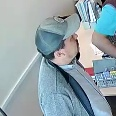

Нет человека


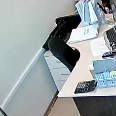

Есть человек


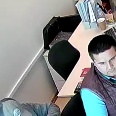

Есть человек


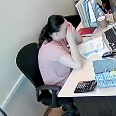

Есть человек


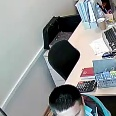

Есть человек


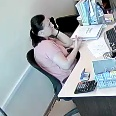

Есть человек


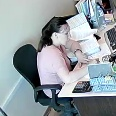

Нет человека


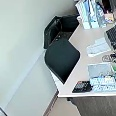

Есть человек


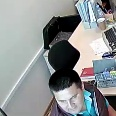

Есть человек


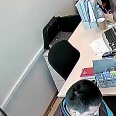

In [22]:
import os
import random as rnd

list_with_people = os.listdir('./people/with_person')
list_without_people = os.listdir('./people/without_person')

for _ in range(10):
    if rnd.randint(0, 1) == 0:
        random_choice = rnd.choice(list_with_people)
        RandomImagePrediction(f'./people/with_person/{random_choice}')
        display(img_ipyt(f'./people/with_person/{random_choice}'))
    else:
        random_choice = rnd.choice(list_without_people)
        RandomImagePrediction(f'./people/without_person/{random_choice}')
        display(img_ipyt(f'./people/without_person/{random_choice}'))